# **Imports**

In [36]:
import os,shutil
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
import pydicom as dicom
from skimage.transform import resize
import cv2
import seaborn as sns
sns.set_style('darkgrid')

In [2]:
os.listdir('/kaggle/input/rsna-pneumonia-detection-challenge')

['stage_2_sample_submission.csv',
 'stage_2_train_images',
 'GCP Credits Request Link - RSNA.txt',
 'stage_2_test_images',
 'stage_2_train_labels.csv',
 'stage_2_detailed_class_info.csv']

# **Reading The Metadata**

In [3]:
df=pd.read_csv('/kaggle/input/rsna-pneumonia-detection-challenge/stage_2_train_labels.csv')
df.head()

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1


In [4]:
df['path']='/kaggle/input/rsna-pneumonia-detection-challenge/stage_2_train_images/'+df['patientId'].astype(str)+'.dcm'

In [5]:
df['path'][0]

'/kaggle/input/rsna-pneumonia-detection-challenge/stage_2_train_images/0004cfab-14fd-4e49-80ba-63a80b6bddd6.dcm'

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30227 entries, 0 to 30226
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   patientId  30227 non-null  object 
 1   x          9555 non-null   float64
 2   y          9555 non-null   float64
 3   width      9555 non-null   float64
 4   height     9555 non-null   float64
 5   Target     30227 non-null  int64  
 6   path       30227 non-null  object 
dtypes: float64(4), int64(1), object(2)
memory usage: 1.6+ MB


In [7]:
negative=df[df['Target']==0]
print(len(negative))
negative.head()

20672


,patientId,x,y,width,height,Target,path
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,/kaggle/input/rsna-pneumonia-detection-challen...
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0,/kaggle/input/rsna-pneumonia-detection-challen...
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0,/kaggle/input/rsna-pneumonia-detection-challen...
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0,/kaggle/input/rsna-pneumonia-detection-challen...
6,00569f44-917d-4c86-a842-81832af98c30,NaN,NaN,NaN,NaN,0,/kaggle/input/rsna-pneumonia-detection-challen...


In [8]:
positive=df[df['Target']==1]
unique_positive=positive[['path','patientId']]
path=unique_positive['path'].unique()
patientId=unique_positive['patientId'].unique()

In [9]:
unique_positive=pd.DataFrame({'path':path,'patientId':patientId})

# **Heatmap of the abnormalities**

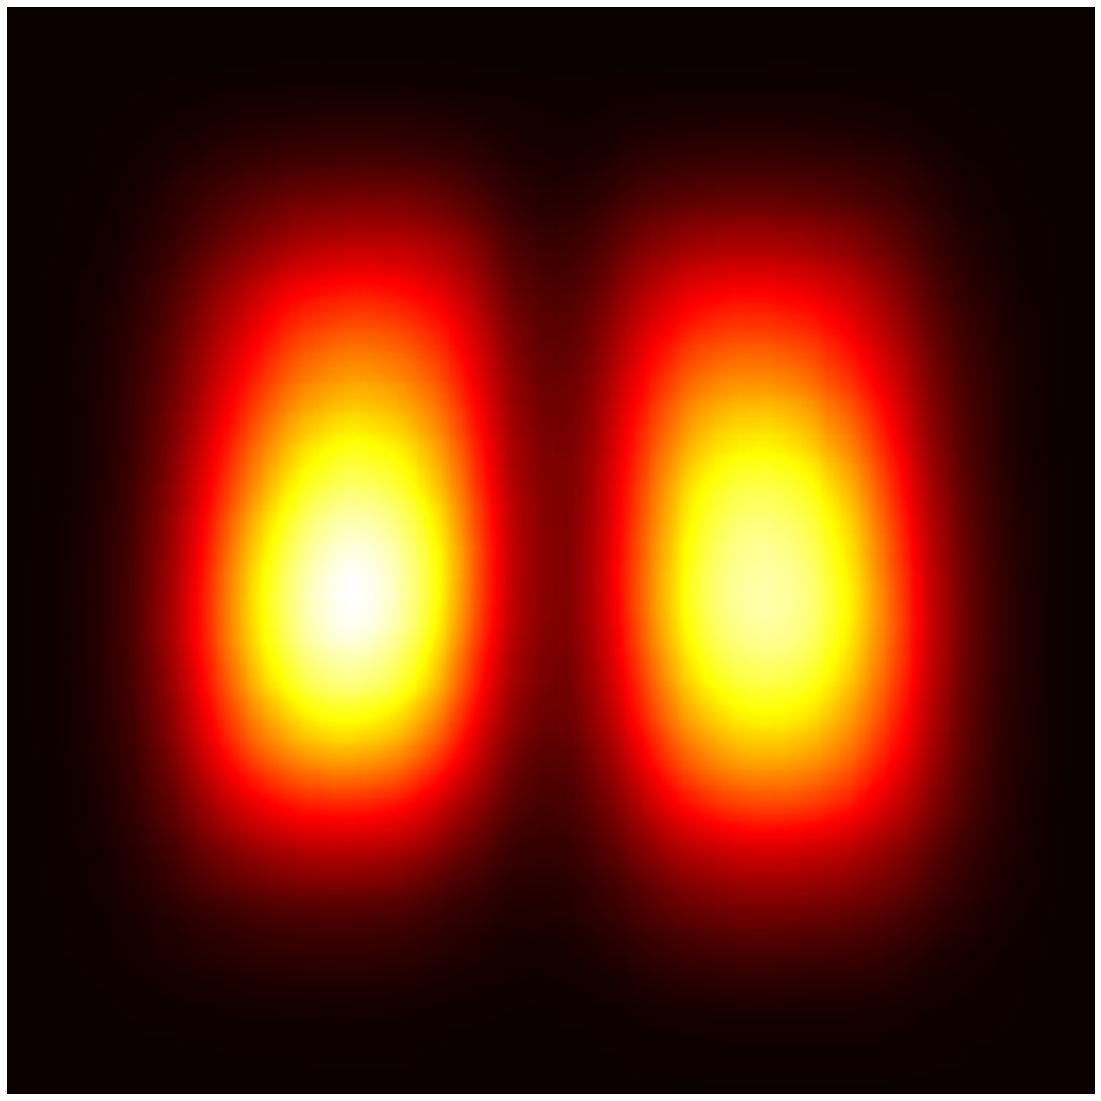

In [45]:
plt.figure(figsize=(30,20))

heatmap=np.zeros((1024,1024))

for _,row in df.iterrows():
    if row['Target']==1:
        x=int(row['x'])
        y=int(row['y'])
        w=int(row['width'])
        h=int(row['height'])
        heatmap[y:y+h,x:x+w]+=1

plt.axis('off')

plt.imshow(heatmap,cmap='hot')
    


# **Storing jpg files**

In [10]:
os.mkdir('/kaggle/working/data')

os.mkdir('/kaggle/working/data/positive')

os.mkdir('/kaggle/working/data/negative')

In [11]:
os.chdir('/kaggle/working')

In [12]:
for _,row in tqdm(unique_positive.iterrows()):
    img=dicom.read_file(row['path']).pixel_array
    img=resize(img,(256,256))
    plt.imsave('data/positive/'+row['patientId']+'.jpg',img,cmap='gray')

6012it [05:45, 17.43it/s]


In [13]:
for _,row in tqdm(negative.iterrows()):
    img=dicom.read_file(row['path']).pixel_array
    img=resize(img,(256,256))
    plt.imsave('data/negative/'+row['patientId']+'.jpg',img,cmap='gray')

20672it [20:14, 17.02it/s]


# **Random Samples**

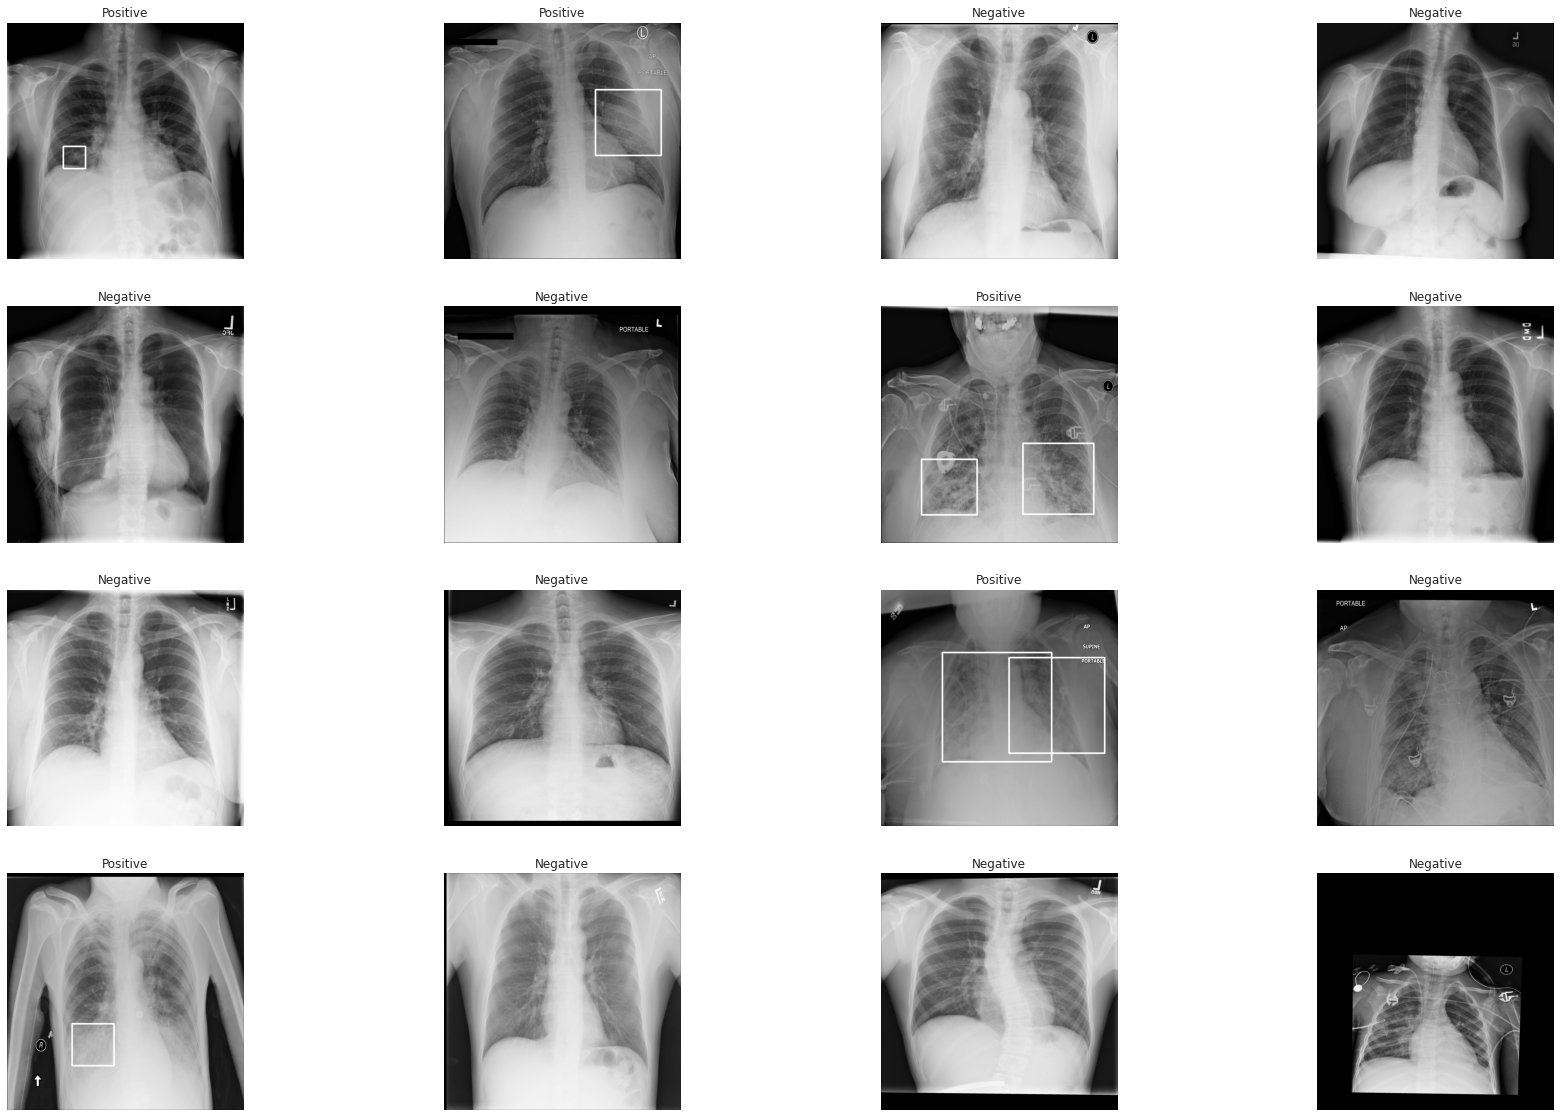

In [51]:
plt.figure(figsize=(30,20))
for j,img in enumerate(os.listdir('/kaggle/input/rsna-pneumonia-detection-challenge/stage_2_train_images')):
    path=os.path.join('/kaggle/input/rsna-pneumonia-detection-challenge/stage_2_train_images',img)
    tar=df[df['path']==path]['Target'].values[0]
    img=dicom.read_file(path).pixel_array
    plt.subplot(4,4,j+1)
    plt.axis('off')
    if tar==0:
        plt.title('Negative')
    else:
        plt.title('Positive')
        
        s=df[df['path']==path]
        
        for _,row in s.iterrows():
            x=int(row['x'])
            y=int(row['y'])
            w=int(row['width'])
            h=int(row['height'])
            cv2.rectangle(img,(x,y),(x+h,y+h),(255,255,0),5)
    plt.imshow(img,cmap='gray')
    if(j==15):
        break

# **Training**

In [15]:
from tensorflow.keras.applications.vgg19 import VGG19,preprocess_input

In [16]:
datagen=ImageDataGenerator(samplewise_center=True,samplewise_std_normalization=True,horizontal_flip=True,
                          width_shift_range=0.05,rescale=1/255,fill_mode='nearest',
                           preprocessing_function=preprocess_input,validation_split=0.1)

In [17]:
train=datagen.flow_from_directory('data',color_mode='rgb',batch_size=64,class_mode='binary',subset='training')
test=datagen.flow_from_directory('data',color_mode='rgb',batch_size=32,class_mode='binary',subset='validation')

Found 24016 images belonging to 2 classes.
Found 2668 images belonging to 2 classes.


In [18]:
train.class_indices

{'negative': 0, 'positive': 1}

In [19]:
pre_trained_model = VGG19(input_shape = (256,256,3), 
                                include_top = False, 
                                weights = 'imagenet')

for layer in pre_trained_model.layers:
  layer.trainable = False

# pre_trained_model.summary()

last_layer = pre_trained_model.get_layer('block5_pool')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

80142336/80134624 [==============================] - 1s 0us/step
last layer output shape:  (None, 8, 8, 512)


In [20]:
from tensorflow.keras.layers import Flatten,Dense,Dropout,BatchNormalization,LeakyReLU

model = Flatten()(last_output)
model = Dense(1024)(model)
model=LeakyReLU(0.1)(model)
model=Dropout(0.2)(model)
model=BatchNormalization()(model)
model = Dense(1, activation='sigmoid')(model)

In [21]:
from tensorflow.keras.models import Model


fmodel = Model( pre_trained_model.input, model) 

fmodel.compile(optimizer = 'adam', 
              loss = 'binary_crossentropy', 
              metrics = ['accuracy'])
fmodel.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0     

In [22]:
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau


early=EarlyStopping(monitor='accuracy',patience=3,mode='auto')
reduce_lr = ReduceLROnPlateau(monitor='accuracy', factor=0.5, patience=2, verbose=1,cooldown=0, mode='auto',min_delta=0.0001, min_lr=0)

In [23]:
class_weight={0:1,1:3.1}

In [24]:
fmodel.fit(train,epochs=50,callbacks=[reduce_lr],steps_per_epoch=100,validation_data=test,class_weight=class_weight)

Train for 100 steps, validate for 84 steps
Epoch 1/50
100/100 [==============================] - 184s 2s/step - loss: 1.0913 - accuracy: 0.7073 - val_loss: 0.9325 - val_accuracy: 0.8452
Epoch 2/50
100/100 [==============================] - 185s 2s/step - loss: 0.8092 - accuracy: 0.7371 - val_loss: 0.6552 - val_accuracy: 0.8178
Epoch 3/50
100/100 [==============================] - 177s 2s/step - loss: 0.7715 - accuracy: 0.7530 - val_loss: 0.6715 - val_accuracy: 0.8197
Epoch 4/50
100/100 [==============================] - 180s 2s/step - loss: 0.7474 - accuracy: 0.7589 - val_loss: 0.6496 - val_accuracy: 0.8133
Epoch 5/50
100/100 [==============================] - 180s 2s/step - loss: 0.7444 - accuracy: 0.7656 - val_loss: 0.6358 - val_accuracy: 0.8250
Epoch 6/50
100/100 [==============================] - 179s 2s/step - loss: 0.7313 - accuracy: 0.7675 - val_loss: 0.6433 - val_accuracy: 0.8043
Epoch 7/50
100/100 [==============================] - 181s 2s/step - loss: 0.7227 - accuracy: 0.773

Epoch 45/50
100/100 [==============================] - 158s 2s/step - loss: 0.6070 - accuracy: 0.8070 - val_loss: 0.6513 - val_accuracy: 0.8253
Epoch 46/50
 99/100 [============================>.] - ETA: 1s - loss: 0.6147 - accuracy: 0.8038
Epoch 00046: ReduceLROnPlateau reducing learning rate to 1.2207031829802872e-07.
100/100 [==============================] - 157s 2s/step - loss: 0.6167 - accuracy: 0.8037 - val_loss: 0.6557 - val_accuracy: 0.8216
Epoch 47/50
100/100 [==============================] - 158s 2s/step - loss: 0.5874 - accuracy: 0.8117 - val_loss: 0.6501 - val_accuracy: 0.8227
Epoch 48/50
100/100 [==============================] - 160s 2s/step - loss: 0.6064 - accuracy: 0.8089 - val_loss: 0.6500 - val_accuracy: 0.8208
Epoch 49/50
 99/100 [============================>.] - ETA: 1s - loss: 0.6192 - accuracy: 0.8080
Epoch 00049: ReduceLROnPlateau reducing learning rate to 6.103515914901436e-08.
100/100 [==============================] - 157s 2s/step - loss: 0.6191 - accuracy

# **Evaluation**

In [25]:
fmodel.save('/kaggle/working/model.h5')

<Figure size 2160x1440 with 0 Axes>

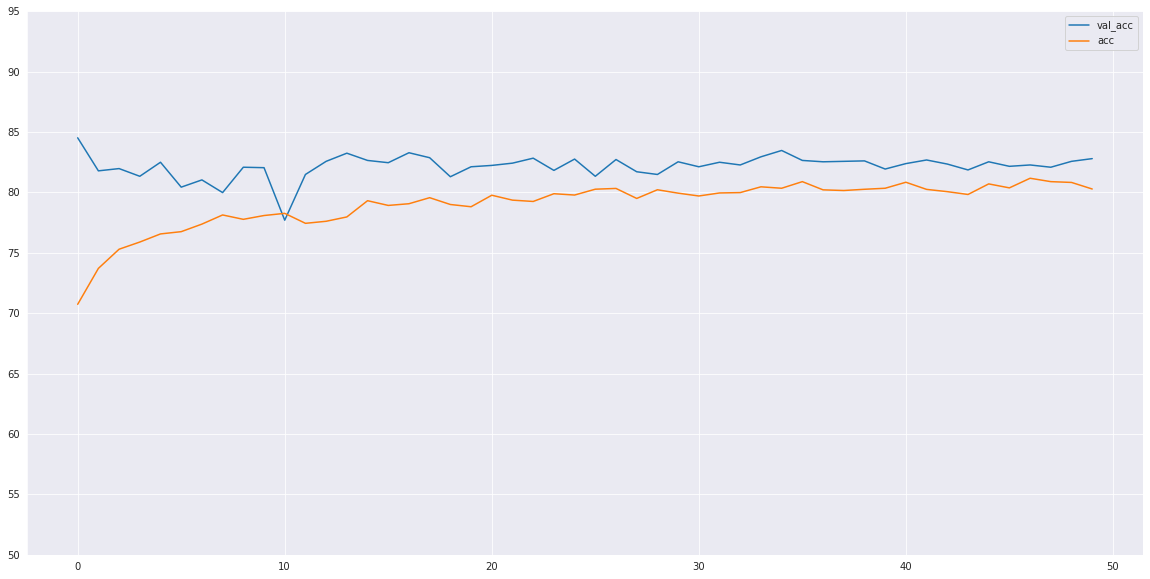

In [37]:
plt.figure(figsize=(30,20))
val_acc=np.asarray(fmodel.history.history['val_accuracy'])*100
acc=np.asarray(fmodel.history.history['accuracy'])*100
acc=pd.DataFrame({'val_acc':val_acc,'acc':acc})
acc.plot(figsize=(20,10),yticks=range(50,100,5))

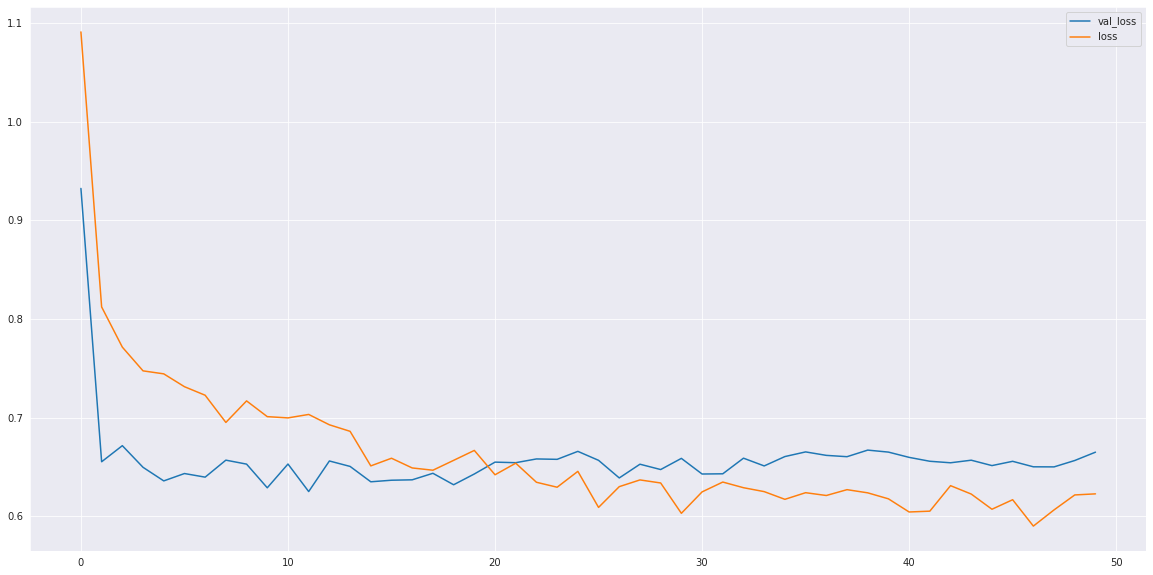

In [38]:
loss=fmodel.history.history['loss']
val_loss=fmodel.history.history['val_loss']
loss=pd.DataFrame({'val_loss':val_loss,'loss':loss})
loss.plot(figsize=(20,10))

In [28]:
y=[]

test.reset()

for i in tqdm(range(84)):
    _,tar=test.__getitem__(i)
    for j in tar:
        y.append(j)

100%|██████████| 84/84 [00:40<00:00,  2.08it/s]


In [29]:
test.reset()
y_pred=fmodel.predict(test)

In [30]:
pred_y=[]
for i in y_pred:
    if i>=0.5:
        pred_y.append(1)
    else:
        pred_y.append(0)

In [31]:
from sklearn.metrics import roc_curve,auc,precision_recall_curve,classification_report

In [32]:
print(classification_report(y,pred_y))

              precision    recall  f1-score   support

         0.0       0.91      0.86      0.89      2067
         1.0       0.60      0.71      0.65       601

    accuracy                           0.83      2668
   macro avg       0.76      0.79      0.77      2668
weighted avg       0.84      0.83      0.83      2668



The area under the curve is: 0.7861945137397999


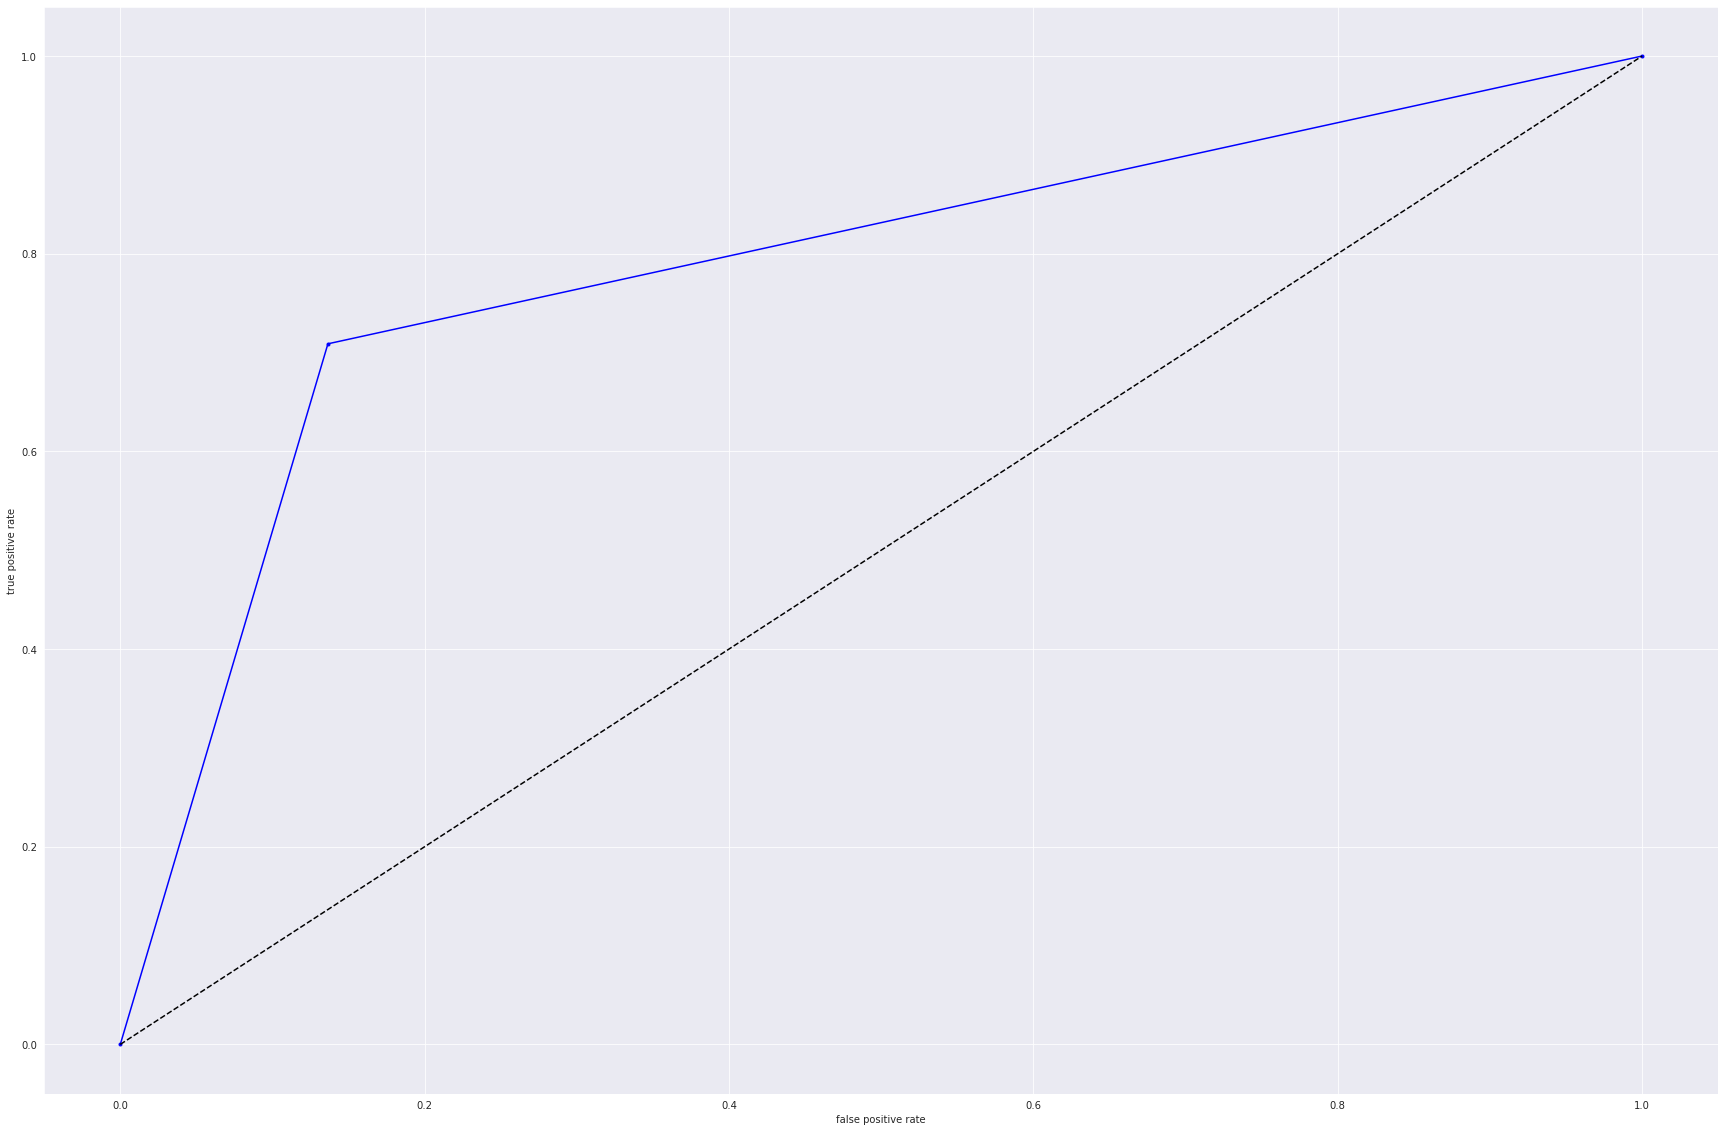

In [39]:
plt.figure(figsize=(30,20))
fpr,tpr,_=roc_curve(y,pred_y)
area_under_curve=auc(fpr,tpr)
print('The area under the curve is:',area_under_curve)
plt.plot(fpr,tpr,'b.-')
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.plot(fpr,fpr,linestyle='--',color='black')